In [1]:
from Feature_Extraction import *
from threading import Thread
import concurrent.futures as conc
import cv2
import os
import math
import dlib
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_real_frame_folders = [
    '../../../archive/original_sequences/youtube/c23/videos/',
]

train_fake_frame_folders = [
    '../../../archive/manipulated_sequences/Deepfakes/c23/videos/',
    '../../../archive/manipulated_sequences/Face2Face/c23/videos/',
    '../../../archive/manipulated_sequences/FaceSwap/c23/videos/',
    '../../../archive/manipulated_sequences/NeuralTextures/c23/videos/',
]

In [3]:
real_videos_paths = []
fake_videos_paths = []
real_azi_vectors = []
fake_azi_vectors = []
reduced_dim_real_vectors = []
reduced_dim_fake_vectors = []

In [4]:
# load the real videos paths into paths list
for train_frame_folder in train_real_frame_folders:
    list_of_train_data = [os.path.join(train_frame_folder, f) for f in os.listdir(
        train_frame_folder) if f.endswith('.mp4')]
    real_videos_paths += list_of_train_data

# load the fake videos paths into paths list
for train_frame_folder in train_fake_frame_folders:
    list_of_train_data = [os.path.join(train_frame_folder, f) for f in os.listdir(
        train_frame_folder) if f.endswith('.mp4')]
    fake_videos_paths.append(list_of_train_data )

### Real videos features extraction

[[32.74825371 25.22082337 27.03339858 ... 33.15185366 27.03339858
  25.22082337]
 [30.85187944 33.16622572 29.039366   ... 28.15465146 29.18952253
  31.05285064]
 [30.91240109 26.81798474 30.82566924 ... 32.13764903 21.97322482
  27.71897618]
 ...
 [29.55536628 29.13153616 20.67600963 ... 29.9407478  22.94610402
  25.67834318]
 [30.91240109 27.71897618 21.97322482 ... 27.91727118 30.82566924
  26.81798474]
 [30.85187944 31.05285064 29.18952253 ... 24.11592029 29.039366
  33.16622572]]
[      0.           23932.8890629    39184.67634231   56368.66838197
   71817.06543336   84501.59637741  102236.65277687  117668.04110179
  124281.85355243  141165.21932926  153541.1940792   168194.22613853
  173403.43102474  182941.00785249  194750.62952037  207988.65108359
  219167.5987149   223320.52675522  234113.98494962  242016.01904175
  257394.46583127  260336.18801584  276098.82401244  285389.12905657
  288860.58260181  290073.16900057  299794.81821399  321536.68626307
  330814.24246216  332697.6

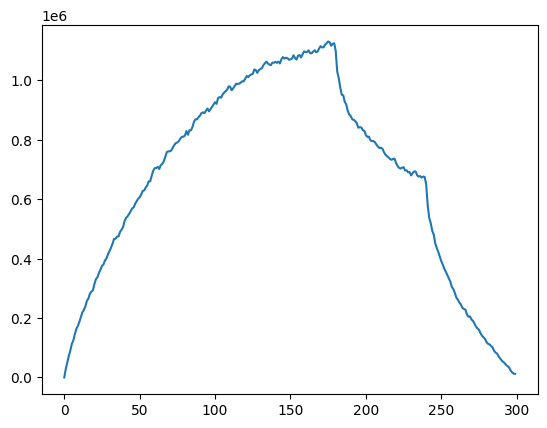

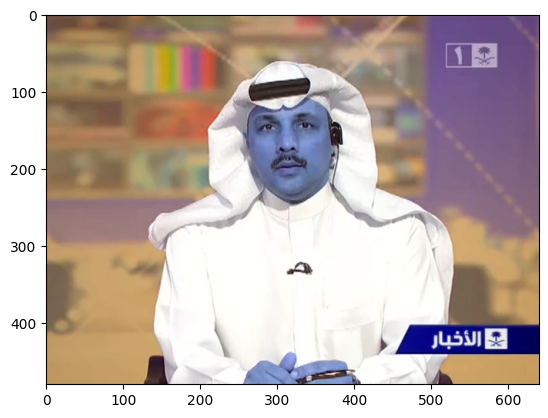

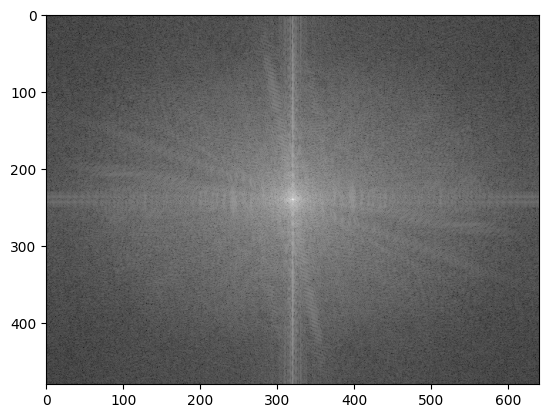

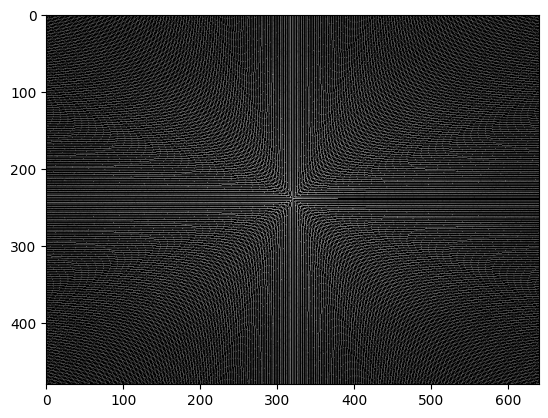

In [5]:
# make a worker pool with max threadings 10
threads = []
feat_ext = Feature_Extraction()

for i, video_path in enumerate(real_videos_paths):
    # Video capturing constructor
    cap = cv2.VideoCapture(video_path)
    
    _ , frame = cap.read()
    face_image = detect_face(frame)
    dft_image = feat_ext.dft(face_image)
    # normalized_dft_image = 100 * np.log(cv2.normalize(dft_image, None, 0, 255, cv2.NORM_MINMAX) + 1)
    azi_line , mod_dft_image = feat_ext.azimuthal_integration(np.array(dft_image))
    normalized_azi_line = feat_ext.line_interpolate(azi_line)
    print(azi_line)
    x = np.arange(300)
    plt.plot(x, normalized_azi_line)
    plt.show()

    plt.imshow(face_image)
    plt.show()
    plt.imshow(dft_image, cmap='gray')
    plt.show()
    plt.imshow(mod_dft_image, cmap='gray')
    plt.show()
    break

    # starting the thread
    t = Thread(target=video_feature_extraction, args=(cap, real_azi_vectors, i,))
    threads.append(t)
    t.start()

    if (i + 1) % 1 == 0:
        for thread in threads:
            thread.join()
        threads = []
        break

In [16]:
print(np.array(real_azi_vectors).shape)

(10, 300)


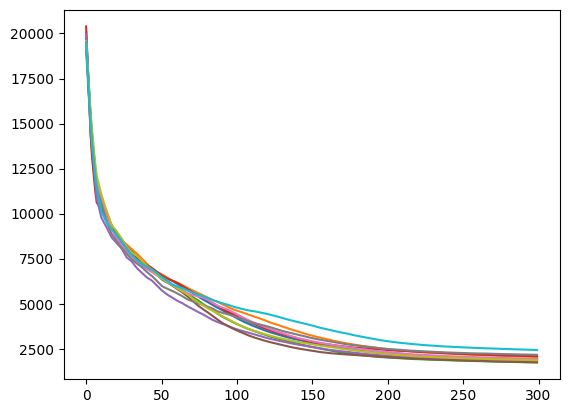

In [17]:
x = np.arange(300)
for plot in real_azi_vectors:
    plt.plot(x, plot)
plt.show()

In [ ]:
# Extract the features into csv file
real_videos_features_df = pd.DataFrame(data = real_azi_vectors)
real_videos_features_df['Label'] = 0
real_videos_features_df.to_csv('real_videos_features_vector.csv')

### Fake videos features extraction

In [18]:
# make a worker pool with max threadings 10
threads = []

for i, dir in enumerate(fake_videos_paths):
    # empty the list before extraction
    fake_azi_vectors = []
    for j, video_path in enumerate(dir):
        # Video capturing constructor
        cap = cv2.VideoCapture(video_path)
        
        # starting the thread
        t = Thread(target=video_feature_extraction, args=(cap, fake_azi_vectors, j,))
        threads.append(t)
        t.start()

        if (j + 1) % 10 == 0:
            for thread in threads:
                thread.join()
            threads = []
            break
    break
    
    # extract the csv file for the current fake dir
    # fake_videos_features_df = pd.DataFrame(data = fake_azi_vectors)
    # fake_videos_features_df['Label'] = 1
    # fake_videos_features_df.to_csv('fake_videos_features_vector_{}.csv'.format(i))

Video 0
Video 1
Video 2
Video 3
Video 4
Video 5
Video 6
Video 7
Video 8
Video 9
Video 3 ---- Done
Video 0 ---- Done
Video 5 ---- Done
Video 7 ---- Done
Video 9 ---- Done
Video 8 ---- Done
Video 6 ---- Done
Video 4 ---- Done
Video 1 ---- Done
Video 2 ---- Done


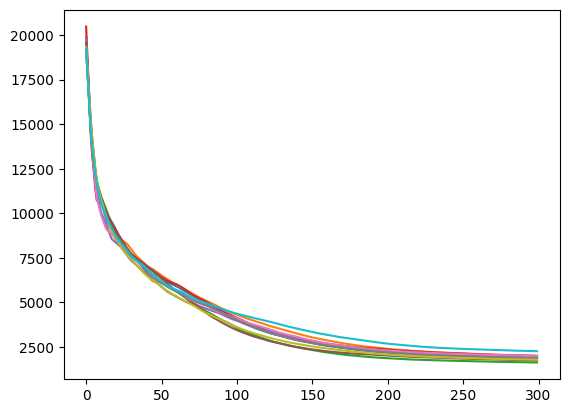

In [19]:
x = np.arange(300)
for plot in fake_azi_vectors:
    plt.plot(x, plot)
plt.show()

In [20]:
# normalize the lines 
concantenated_azi_vectors = np.concatenate([real_azi_vectors, fake_azi_vectors])
means = np.mean(concantenated_azi_vectors, axis=0)
vars = np.var(concantenated_azi_vectors, axis=0)

normolized_real_azi_vectors = (real_azi_vectors - means) / vars
normalized_fake_azi_vectors = (fake_azi_vectors - means) / vars

In [21]:
print(concantenated_azi_vectors.shape)

(20, 300)


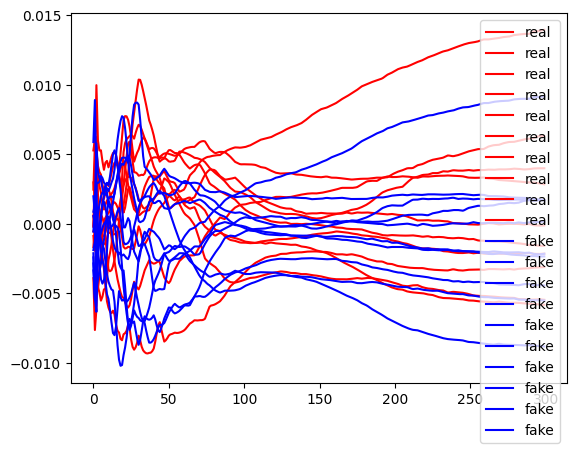

In [22]:
x = np.arange(300)
for plot in normolized_real_azi_vectors:
    plt.plot(x, plot, c='r', label='real')
for plot in normalized_fake_azi_vectors:
    plt.plot(x, plot, c='b', label='fake')

plt.legend()
plt.show()

In [6]:
np.linspace(0, 10, 0)


array([], dtype=float64)